# Processing text, extracting and visualising descriptive statistics

In [ ]:
### TO DO:
# 8. generalised visualisations function
# 9. write the README file regarding general overivew, technicalities, packages and usage
# 10. include file exports for all author visualisations 
# 11. think about trade-offs in storing certain columns as named tuples (e.g. pos word pairs). easier to understand/extract
# information compared to 

### Important note:
# 1. the current implementation is that each time process_one_author is run, it appends to the file. so if you run it 
# you will have twice the same information in the file. 
# 2. the files are currently written with "\t" between elements for the same sentence, except named entites where 
# there is a sub-cat of info. these are separated by "\t\t".
# 3. each line (for each sentence) is separated by a "\n"

In [1]:
import os, re, glob, pickle, string, collections
from os import path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pg_dataextraction import GutenbergCorpusBuilder, Author
import utils_loaddataframe, utils_tokeniser, utils_statsgenerator

[nltk_data] Downloading package benepar_en2 to
[nltk_data]     /Users/k1000mbp/nltk_data...
[nltk_data]   Package benepar_en2 is already up-to-date!


### 0. Load the data

##### Load the entire set of author-book-sentence attributes we have collected 

In [26]:
corpus_authorbook_df = utils_loaddataframe.loaddataframe()
corpus_authorbook_df.head(2)

,authorabstracts,authorname,literarymovements,wiki_info,booknum,selected_sents,authornum,filename,booktitle
0,"{'en': 'Christian Nephi Anderson (January 22, ...",Anderson Nephi,[lds fiction],{'en': 'http://en.wikipedia.org/wiki/Nephi_And...,16534,[When did Joseph visit Jackson county the seco...,a4501,./data/booksample_txt/a4501_16534.txt,A Young Folks' History of the Church of Jesus ...
1,"{'en': 'Christian Nephi Anderson (January 22, ...",Anderson Nephi,[lds fiction],{'en': 'http://en.wikipedia.org/wiki/Nephi_And...,17249,[It has been revealed to and tried by men in v...,a4501,./data/booksample_txt/a4501_17249.txt,Added Upon\rA Story (English) (as Author)


##### Extract the set of English wikipedia extracts for authors

In [92]:
# slice the df to include only authorabstracts and authornum
authorabstracts_df = corpus_authorbook_df[["authorabstracts", "authornum"]]
# we have duplicate rows based on authornums, let's drop them
authorabstracts_df.drop_duplicates("authornum", inplace=True)
authorabstracts_df.set_index(["authornum"], drop=True, inplace=True)
authorabstracts_df.head(2)


/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,authorabstracts
authornum,
a4501,"{'en': 'Christian Nephi Anderson (January 22, ..."
a25203,"{'en': 'Poul William Anderson (November 25, 19..."


### 1. Preprocessing and Feature Engineering

##### Running the feature generators on authors' sentences

In [2]:
# get all the authornums
data_filenames = glob.glob("./data/booksample_txt/*.txt")
authornums = set([filename.split("/")[-1].split("_")[0] for filename in data_filenames])

# check if they have been processed before. if so do not re-run process_one_author
done_filenames = glob.glob("./processeddata/df_pickles/*.pickle")
done_authornums = set([filename.split("/")[-1].split("_")[0] for filename in done_filenames])

# list comp to remove authornums that have been processed (i.e. have a df_pickle file)
_ = [authornums.remove(i) for i in done_authornums]

##### Run process_one_author #####

# define the postags and parsetags required by the 
select_parsetags = ["NP", "VP"]
select_postags = ["NOUN", 'VERB', 'ADJ', "ADV", "AUX", "INTJ", "NUM", "PRON", "PROPN", "PUNCT"]

for authornum in authornums: 
    __data = utils_tokeniser.process_one_author(authornum, 
                                                functions=[utils_tokeniser.get_sentence,utils_tokeniser.get_tokens,
                                               utils_tokeniser.get_lemmas,utils_tokeniser.get_postags,
                                               utils_tokeniser.get_poswordpairs, utils_tokeniser.get_namedentities,
                                               utils_tokeniser.get_parsetags,utils_tokeniser.get_concreteness],
                                               overwrite_files=True)
    # generate the dataframes containing information about each author, with each row as an instance (in this case, 
    # a sentence from one of the author's books)
    __data_df = utils_tokeniser.generate_dataframe(authornum, __data)
    __data_df.to_pickle("./processeddata/df_pickles/{}_df.pickle".format(authornum))

##### Running the feature generators on authors' wiki abstracts

In [96]:
authorabstracts_df["namedentities"] =  authorabstracts_df["authorabstracts"].apply(lambda x: utils_tokeniser.get_namedentities(utils_tokeniser.create_spacysentdoc(
x["en"]))[1])
authorabstracts_df.head(2)                                                                   

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,authorabstracts,NERS,namedentities
authornum,,,
a4501,"{'en': 'Christian Nephi Anderson (January 22, ...","{'places': [], 'persons': ['Nephi Anderson'], ...","{'places': [], 'persons': ['Nephi Anderson'], ..."
a25203,"{'en': 'Poul William Anderson (November 25, 19...","{'places': [], 'persons': ['Poul William Ander...","{'places': [], 'persons': ['Poul William Ander..."


In [136]:
all_sent = []
for sentence_num in authorabstracts_df.index:
    one_sent={}
    col_names = [ne_type for ne_type in authorabstracts_df["namedentities"][sentence_num]]
    ne_dict = {ne_type:[] for ne_type in col_names}
    for col_name in col_names:
        ne_dict[col_name] = authorabstracts_df["namedentities"][sentence_num][col_name]
    for key2 in ne_dict:
        one_sent["ne_wiki"+key2] = ne_dict[key2]
    all_sent.append(one_sent)
    
    
authorabstracts_NE_df= pd.DataFrame(all_sent, index = authorabstracts_df.index)
authorabstracts_NE_df.head(2)

,ne_wikidates,ne_wikipersons,ne_wikiplaces
authornum,,,
a4501,"[January 22, 1865 – January 6, 1923]",[Nephi Anderson],[]
a25203,"[November 25, 1926 – July 31, 2001, the 1940s,...","[Poul William Anderson, Anderson]",[]


In [143]:
# tokenise NE dates, remove months and numbers
# 1. join all NEs in to a single string. (it was initially a set). objective is to easily tokensise all the ne dates 
# at one go. 
authorabstracts_NE_df["ne_wikidates"] = authorabstracts_NE_df["ne_wikidates"].apply(lambda x: " ".join(x))
authorabstracts_NE_df["ne_wikidates"].head(2)

authornum
a4501                        january 22 1865 january 6 1923
a25203    november 25 1926 july 31 2001 the 1940s the 21...
Name: ne_wikidates, dtype: object

In [144]:
# 2. tokenise the entire ne date string
authorabstracts_NE_df["ne_wikidates"]= authorabstracts_NE_df["ne_wikidates"].apply(lambda x: utils_tokeniser.get_tokens(utils_tokeniser.create_spacysentdoc(x))[1])
authorabstracts_NE_df["ne_wikidates"].head(2)

authornum
a4501                 [january, 22, 1865, january, 6, 1923]
a25203    [november, 25, 1926, july, 31, 2001, the, 1940...
Name: ne_wikidates, dtype: object

In [159]:
# extract only ne date tokens that are exactly 4-digit numeric (corresponding to years)
authorabstracts_NE_df["ne_wikidates"] = authorabstracts_NE_df["ne_wikidates"].apply(lambda x: [i for i in x if re.match(r'[1-9]{4}$' , i) ] )
authorabstracts_NE_df["ne_wikidates"].head(2)

authornum
a4501     [1865, 1923]
a25203          [1926]
Name: ne_wikidates, dtype: object

In [162]:
# round the dates up to decades, so that we don't have a sparsity problem from vectorisation
authorabstracts_NE_df["ne_wikidates"] = authorabstracts_NE_df["ne_wikidates"].apply(lambda x: [round(int(i),-1) for i in x] )
authorabstracts_NE_df["ne_wikidates"].head(2)

authornum
a4501     [1860, 1920]
a25203          [1930]
Name: ne_wikidates, dtype: object

In [164]:
# export to pickle 
authorabstracts_NE_df.to_pickle("./processeddata/df_pickle_abstracts/authors_abstract_nes.pickle")

##### Generate a toy dataset for a narrow EDA into subcorpuses

In [3]:
# call utils_tokeniser.process_one_author on 2 authors to generate a toy dataset
a4501 = utils_tokeniser.process_one_author("a4501", functions=[utils_tokeniser.get_sentence,utils_tokeniser.get_tokens,
                                               utils_tokeniser.get_lemmas,utils_tokeniser.get_postags,
                                               utils_tokeniser.get_poswordpairs, utils_tokeniser.get_namedentities,
                                               utils_tokeniser.get_parsetags,utils_tokeniser.get_concreteness],
                                               overwrite_files=True)

a206 = utils_tokeniser.process_one_author("a206", functions=[utils_tokeniser.get_sentence,utils_tokeniser.get_tokens,
                                               utils_tokeniser.get_lemmas,utils_tokeniser.get_postags,
                                               utils_tokeniser.get_poswordpairs, utils_tokeniser.get_namedentities,
                                               utils_tokeniser.get_parsetags,utils_tokeniser.get_concreteness],
                                               overwrite_files=True)

# Generating a dataframe with all the feature generators
# for the purpose of this exercise, store the results in an iterable dict
a4501_df = utils_tokeniser.generate_dataframe("a4501", a4501, select_postags, select_parsetags)
a4501_df.head(2)    

a206_df = utils_tokeniser.generate_dataframe("a206", a206, select_postags, select_parsetags)
a206_df.head(2)

author_dfs_x2 = {"a4501":a4501_df, "a206": a206_df}

### 2. Descriptive statistics

##### 2a. Vocabulary size - author 

In [4]:
vocab_dict = {}
for author_dfs_x2_key in author_dfs_x2:
    vocab = set()
    for sent in author_dfs_x2[author_dfs_x2_key]["tokens"]:
        vocab.update(sent)
    vocab_dict[ author_dfs_x2_key]=len(vocab)
    print("We have a vocabulary size of {} for the author {}".format(len(vocab),author_dfs_x2_key, ))

We have a vocabulary size of 1136 for the author a4501
We have a vocabulary size of 1226 for the author a206


##### 2b. Max, min, average sentence length

In [5]:
maxminavg_dict = {}
for author_dfs_x2_key in author_dfs_x2:
    maxminavg = [max(author_dfs_x2[author_dfs_x2_key]["sent_length"]), 
                 min(author_dfs_x2[author_dfs_x2_key]["sent_length"]), 
                 sum(author_dfs_x2[author_dfs_x2_key]["sent_length"])/len(a4501_df)]
    maxminavg_dict[author_dfs_x2_key] = maxminavg
    print("sentence_lengths for author {} | _max_: {}, _min_: {}, _avg_: {}".format(author_dfs_x2_key,
                                                                              maxminavg[0],maxminavg[1],
                                                                              maxminavg[2]))

sentence_lengths for author a4501 | _max_: 49, _min_: 1, _avg_: 14.19277108433735
sentence_lengths for author a206 | _max_: 67, _min_: 0, _avg_: 11.899598393574298


##### 2c. POS distribution

In [6]:
for author_dfs_x2_key in author_dfs_x2:
    pos_dist = author_dfs_x2[author_dfs_x2_key][["pos_"+postag for postag in select_postags]].sum()
    pos_dist.sort_values(inplace=True)
    print("POS tag distribution for {}".format(author_dfs_x2_key), "\n", pos_dist, "\n\n")

POS tag distribution for a4501 
 pos_AUX        0
pos_INTJ      19
pos_NUM       38
pos_PROPN    192
pos_ADV      261
pos_PRON     270
pos_ADJ      292
pos_PUNCT    624
pos_NOUN     627
pos_VERB     728
dtype: int64 


POS tag distribution for a206 
 pos_AUX        0
pos_INTJ      11
pos_NUM       33
pos_ADV      141
pos_PRON     167
pos_PROPN    235
pos_ADJ      277
pos_VERB     549
pos_NOUN     585
pos_PUNCT    627
dtype: int64 




##### 2d. Most frequent named entities

In [7]:
# max length of sentences
NERs = list()
for sent in a206["namedentities"]:
    for type_ in sent:
        NERs.extend(sent[type_])
collections.Counter(NERs).most_common(10)

[('Farquhar', 5),
 ('Lion', 2),
 ('Farmer', 2),
 ('Ambrose Bierce', 2),
 ('Alabama', 1),
 ('a month ago', 1),
 ('Proboscidae', 1),
 ('Cock', 1),
 ('Ferryman', 1),
 ('the King of the FlySpeck Islands', 1)]

##### 2e. Min, max, average NPs and VPs per sentence

The following statistics are for author a4501, Anderson, Nephi https://www.gutenberg.org/ebooks/author/4501 ,

In [10]:
maxminavg = [max(a4501_df["parse_NP"]), min(a4501_df["parse_NP"]), sum(a4501_df["parse_NP"])/len(a4501_df)]
print("NP counts | max: {}, min: {}, avg: {}".format(maxminavg[0],maxminavg[1], maxminavg[2]))

NP counts | max: 22, min: 0, avg: 5.068273092369478


In [11]:
maxminavg = [max(a4501_df["parse_VP"]), min(a4501_df["parse_VP"]), sum(a4501_df["parse_VP"])/len(a4501_df)]
print("VP counts | max: {}, min: {}, avg: {}".format(maxminavg[0],maxminavg[1], maxminavg[2]))

VP counts | max: 13, min: 0, avg: 3.180722891566265


___Some analysis of the constituency patterns of the author___

In [13]:
# Let's take a look at the sentences with the longest NP and VP counts
VP_count = 13
for index in a4501_df[a4501_df["parse_VP"]==VP_count].index:
    print(a4501_df[a4501_df["parse_VP"]==VP_count]["sentences"][index])

My thoughts go out 'Over the high mountains,' as Bjornson says, and I want to be away to hear and see what the world is and has to tell me.
A soul who cannot function in the celestial glory, may do so in the terrestrial glory; one who cannot function in the terrestrial, may in the telestial; and one who cannot 'abide the law' or function in the telestial must find a place of no glory.


In [14]:
NP_count = 22
for index in a4501_df[a4501_df["parse_NP"]==VP_count].index:
    print(a4501_df[a4501_df["parse_NP"]==VP_count]["sentences"][index])

While teaching the people the need of repenting of their evil doings and being baptized for the remission of their sins, Brother Kimball felt someone pulling at his coat: "Please sir, will you baptize me?"
Governor Dunklin talked very pleasantly about the rights of the Saints, but in the end he did nothing to protect the people or help them to gain possession of their property.
His wife and her cousin were from Norway, the former having been in the country long enough to become Americanized; it was two years only since the latter had emigrated from her native land, so she spoke English with a foreign accent.


### 3. Visualisations

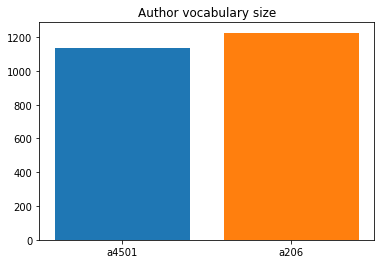

In [15]:
utils_statsgenerator._vocab_barplot(vocab_dict)

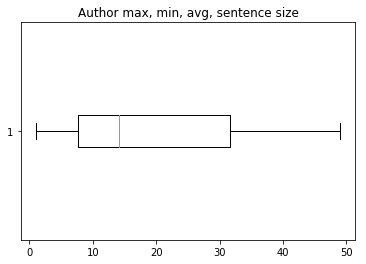

In [16]:
utils_statsgenerator._sentsize_boxplot(maxminavg_dict["a4501"])

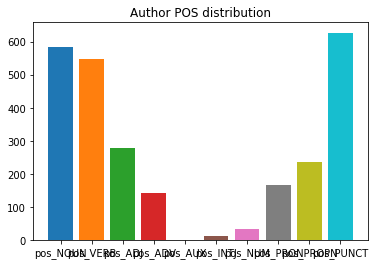

In [24]:
utils_statsgenerator._posdistributions(pos_dist,select_postags)

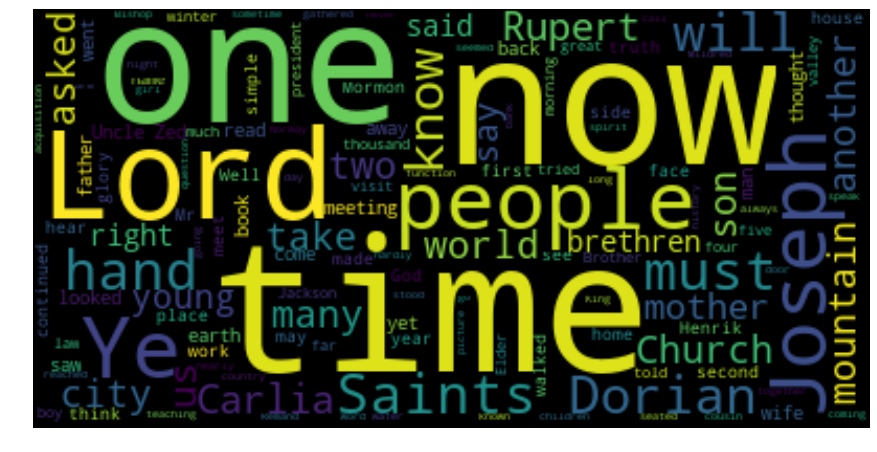

In [18]:
utils_statsgenerator._makecloud(a4501_df["sentences"].sum())